Discente: Helvecio Bezerra Leal Neto

Doscente: Dr. Marcos Quiles

### Projeto 1 - Multilayer Perceptron (MLP)

Utilizar a rede MLP para:
- Realizar testes com 3(ou mais) datasets selecionados do repositório da UCI (iris,
etc...) para várias configuração da rede
- Ilustrar graficamente o processo de aprendizagem pela redução do erro quadrático
médio
- Dividir o conjunto em duas partes (Treino e Validação)
- Entregar um relatório descrevendo os experimentos


Considerar:
- Impacto do termo de momentum
- Impacto da regularização L2

### Bibliotecas

In [1]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [2]:
df = pd.read_csv('dataset/PRSA_data.csv')

In [3]:
print('Tamanho do dataset: ',df.shape[0], ', quantiade de atributos: ', df.shape[1])
df.head()

Tamanho do dataset:  43824 , quantiade de atributos:  13


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [4]:
df['datetime'] = df[['year','month','day','hour']].apply(lambda row:
            datetime.datetime(year=row['year'], month=row['month'], day=row['day'], hour=row['hour']),axis=1)
df.sort_values('datetime', ascending=True,inplace=True)

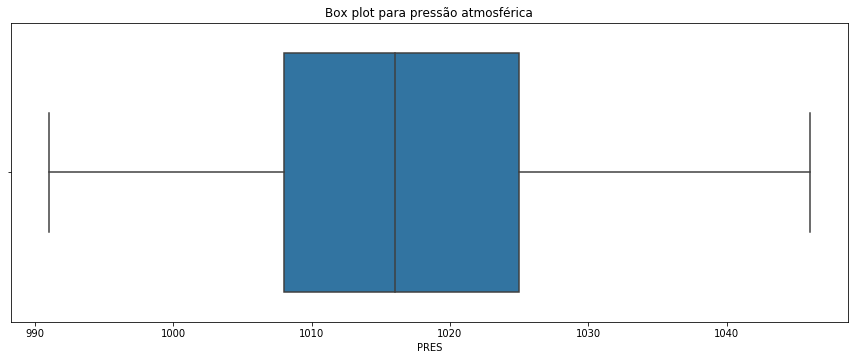

In [5]:
plt.figure(figsize=(15, 5.5))
g = sns.boxplot(df['PRES'])
g.set_title('Box plot para pressão atmosférica')
plt.show()

/ssd/miniconda3/envs/cap351/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


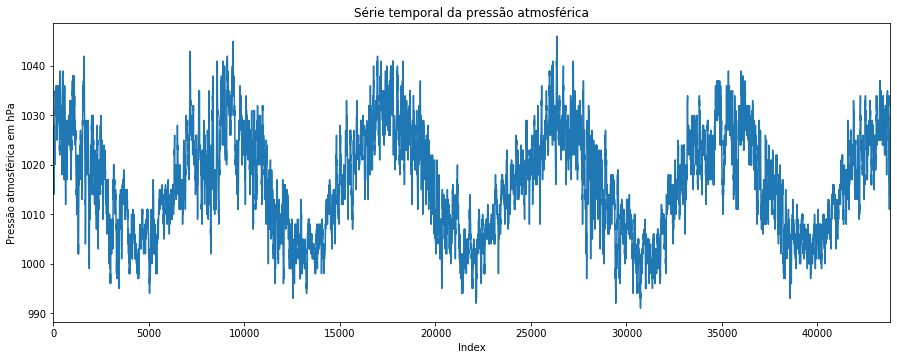

In [6]:
plt.figure(figsize=(15,5.5))
g = sns.tsplot(df['PRES'])
g.set_title('Série temporal da pressão atmosférica')
g.set_xlabel('Index')
g.set_ylabel('Pressão atmosférica em hPa')
plt.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df['scaled_PRES'] = scaler.fit_transform(np.array(df['PRES']).reshape(-1,1))

In [8]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_PRES
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00,0.545455
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00,0.527273
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00,0.509091
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00,0.509091
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00,0.490909


- Split into two parts:
   * Train set - trained neural networks
   * Validation set
   
- Used validation set:
  * Evaluate model
  * Determine number of epochs

In [9]:
## Split Train datetime Year=2014, Month=01 Day = 01 Hour=01
split_date = datetime.datetime(year= 2014, month=1,day=1,hour=0)
df_train = df.loc[df['datetime']<split_date]

df_val = df.loc[df['datetime']>=split_date]

print('Tamanho do dataset para treinamento: ',df_train.shape[0])
print('Tamanho do dataset para validação: ',df_val.shape[0])
df_val.reset_index(drop=True, inplace=True)

Tamanho do dataset para treinamento:  35064
Tamanho do dataset para validação:  8760


/ssd/miniconda3/envs/cap351/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


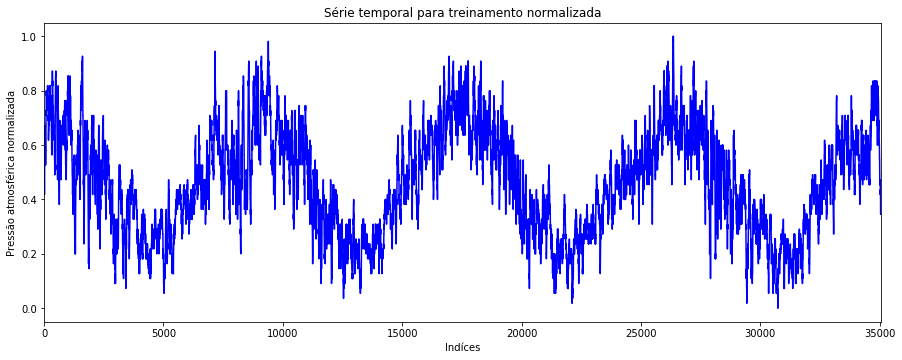

In [10]:
plt.figure(figsize=(15, 5.5))
g = sns.tsplot(df_train['scaled_PRES'], color='b')
g.set_title('Série temporal para treinamento normalizada')
g.set_xlabel('Indíces')
g.set_ylabel('Pressão atmosférica normalizada')
plt.show()

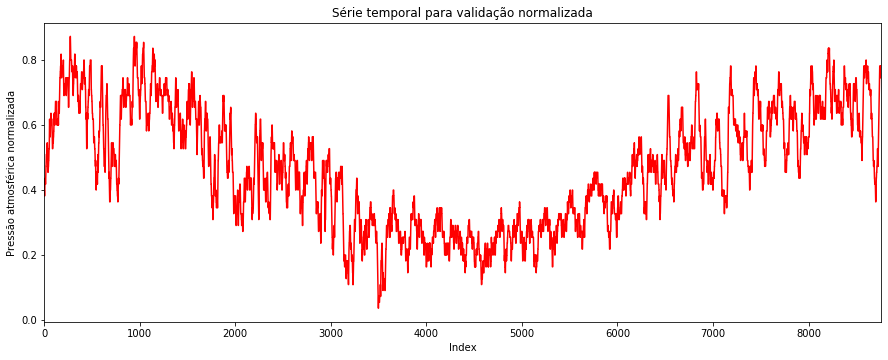

In [11]:
plt.figure(figsize=(15, 5.5))
g = sns.tsplot(df_val['scaled_PRES'], color='r')
g.set_title('Série temporal para validação normalizada')
g.set_xlabel('Index')
g.set_ylabel('Pressão atmosférica normalizada')
plt.show()

Now we need to generate regresses X and target variable Y for train and validation, a 2d array of regressors and one the array of target is created from the original 1d array of the scaled underscore press column in the data frames;

Function that takes the original time series and the number of time steps as input to return the array of X from Y 

In [12]:
def makeYx(ts, nb_timesteps):
    
    X = []
    y = []
    
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
        
    X,y = np.array(X), np.array(y)
    return X,y

In [13]:
X_train, y_train = makeYx(df_train['scaled_PRES'], 7)
print('Tamanho do vetor para treinamento: ', X_train.shape, y_train.shape)

Tamanho do vetor para treinamento:  (35057, 7) (35057,)


In [14]:
X_val, y_val = makeYx(df_val['scaled_PRES'], 7)
print('Tamanho do vetor para validação: ', X_val.shape, y_val.shape)

Tamanho do vetor para validação:  (8753, 7) (8753,)


In [16]:
from keras.layers import Dense, Input, Dropout
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [18]:
# Número de instancias para rodar na primeira camada
input_layer = Input(shape=(7,),dtype='float32')

In [20]:
# camadas densas e função de ativação
dense1 = Dense(32, activation = 'linear')(input_layer)
dense2 = Dense(16, activation = 'linear')(dense1)
dense3 = Dense(16, activation = 'linear')(dense2)

In [22]:
# dropout foi usado para regularizar a rede
# dropout é adicionada antes da camada de saída
# Dropout ajusta aleatoriamente a fração dos neuronis de entrada como zero antes de passar para a próxima camada.
# a entrada aleatória atua essencialmente como agregação de bootstrap ou tipo de encapsulamento dos modelos
# random forests usam ensacamento construindo árvores em subconjuntos aleatórios a partir dos recursos de entrada

# 20% de aleatóriedade para os atributos de entrada
dropout_layer = Dropout(0.2)(dense3)

In [23]:
# o neurônio de saída da o valor de predição para o próximo dia de pressão atmosférica
output_layer = Dense(1, activation='linear')(dropout_layer)

In [24]:
# os valores da camada de entrada e camada de saída são encapsulados em um modelo de treinamento e validação

# O erro quadrado médio (MSE) é usado como função de perda
# a taxa de aprendizado dos pesos é atualizada nas médias móveis ponderadas exponencialmente
# a partir dos gradientes quadráticos dos pesos

# As funções summary exibe detalhes das camada, como o
# - forma de entrada e saída
# - número de pesos treináveis

ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_squared_error',optimizer='adam')
ts_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 1,073
Trainable params: 1,073
Non-trainable params: 0
_________________________________________________________________


In [53]:
# ts_model.evaluate(X_val, y_val,verbose=1)


scores =ts_model.evaluate(X_val, y_val,verbose=1)
# ts_model.metrics_names[1],scores[1]*100
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

8753/8753 [==============================] - 0s 11us/step


O modelo é treinado chamando a função (fit) no objeto do modelo e passando os vetores X_ para treinar e Y_

In [25]:
# um objeto de ponto de verificação de modelo rastreia a função de perda no conjunto de dados de validação e salva a época
# em que a perda da função é mínima
save_weights_at = os.path.join('output','PRSA_data_2010.1.1-2014.12.31.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss',verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
       save_best                     period=1)

In [26]:
# Função FIT
teste1 = ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)


Train on 35057 samples, validate on 8753 samples
Epoch 1/20
35057/35057 [==============================] - 5s 157us/step - loss: 0.0038 - val_loss: 2.0001e-04
Epoch 2/20
35057/35057 [==============================] - 5s 141us/step - loss: 0.0010 - val_loss: 1.5253e-04
Epoch 3/20
35057/35057 [==============================] - 5s 145us/step - loss: 8.3488e-04 - val_loss: 1.4677e-04
Epoch 4/20
35057/35057 [==============================] - 5s 148us/step - loss: 8.0762e-04 - val_loss: 3.3805e-04
Epoch 5/20
35057/35057 [==============================] - 5s 150us/step - loss: 7.8377e-04 - val_loss: 6.7134e-04
Epoch 6/20
35057/35057 [==============================] - 5s 140us/step - loss: 7.9867e-04 - val_loss: 2.3899e-04
Epoch 7/20
35057/35057 [==============================] - 5s 140us/step - loss: 7.7260e-04 - val_loss: 2.9586e-04
Epoch 8/20
35057/35057 [==============================] - 5s 149us/step - loss: 7.5207e-04 - val_loss: 2.2794e-04
Epoch 9/20
35057/35057 [======================

In [57]:
ts_model.save

<bound method Network.save of <keras.engine.training.Model object at 0x7f9bb9728210>>

As previsões de pressão atmosférica são feitas a partir do melhor modelo salvo, os resultados de pressão atmosféricas normalizados são transformados inversamente para obter previsões sobre a pressão atmosférica original.

In [ ]:
best_model = load_model(os.path.join('output', 'PRSA_data_2010.1.1-2014.12.31.04-0.0001.hdf5'))
preds = best_model.predict(X_val)
pred_PRES = scaler.inverse_transform(preds)
pred_PRES = np.squeeze(pred_PRES)

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2 = r2_score(df_val['PRES'].loc[7:], pred_PRES)
print('Erro quadrático para o dataset de validação:', round(r2,4))

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(range(50), df_val['PRES'].loc[7:56], linestyle='-', marker='*', color='r')
plt.plot(range(50), pred_PRES[:50], linestyle='-', marker='.', color='b')
plt.legend(['Atual','Previsão'], loc=2)
plt.title('Atual vs Previsão Pressão atmosférica')
plt.ylabel('Pressão atmosférica')
plt.xlabel('Index')
plt.show()

### Exemplo 02: Dataset INMET

Dataset 1: https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [ ]:
df_mta = pd.read_csv('dataset/dados_monte_alegre.csv', delimiter=';')

In [ ]:
print("Tamanho do dataset: ", df_mta.shape[0], ' quantidade de atributos: ', df_mta.shape[1])
df_mta.head()

In [ ]:
df_mta[['day','month','year']] = df_mta.Data.str.split('/', n = 3, expand = True)
df_mta['day'] = pd.to_numeric(df_mta.day)
df_mta['month'] = pd.to_numeric(df_mta.month)
df_mta['year'] = pd.to_numeric(df_mta.year)
df_mta = df_mta.replace([1200,1800],[12,18])

df_mta['datetime'] = df_mta[['day','month','year','Hora']].apply(lambda row:
                    datetime.datetime(year=row['year'], month=row['month'],day=row['day'],hour=row['Hora']),axis=1)
df_mta = df_mta.drop(columns=['Data','Hora','day','month','year','Unnamed: 10'])
df_mta = df_mta.set_index('datetime')
df_mta.sort_values('datetime',ascending=True,inplace=True)
df_mta.head()

In [ ]:
plt.figure(figsize=(15, 5.5))
g = sns.boxplot(df_mta['TempBulboSeco'])
g.set_title('Variação Temperatura de Bulbo Seco')
plt.show()

In [ ]:
## Separar dados de treinamento
split_date = datetime.datetime(year=2014, month=1,day=1)

df_train_mta = df_mta.loc[df_mta.index<split_date]
df_val_mta = df_mta.loc[df_mta.index>=split_date]

print('Shape do treinamento: ', df_train_mta.shape)
print('Shape da validação: ', df_val_mta.shape)

In [ ]:
df_train_mta.TempBulboSeco.plot(figsize = (20,4), title='Treinamento')

In [ ]:
df_val_mta.TempBulboSeco.plot(figsize = (20,4), title='Teste', color='r')

### Normalização

In [ ]:
scaler_mta = MinMaxScaler(feature_range=(0,1))
df_train_mta['Scaled_TempBulboSeco'] = scaler.fit_transform(np.array(df_train_mta['TempBulboSeco']).reshape(-1,1))
df_val_mta['Scaled_TempBulboSeco'] = scaler.fit_transform(np.array(df_val_mta['TempBulboSeco']).reshape(-1,1))

In [ ]:
df_train_mta.reset_index(inplace=True)
df_val_mta.reset_index(inplace=True)

In [ ]:
X_train_mta, y_train_mta = makeYx(df_train_mta['Scaled_TempBulboSeco'], 3)
print('Tamanho dos vetores de treinamento: ', X_train_mta.shape, y_train_mta.shape)

X_val_mta, y_val_mta = makeYx(df_val_mta['Scaled_TempBulboSeco'], 3)
print('Tamanho dos vetores de validação: ', X_val_mta.shape, y_val_mta.shape)

X_train_mta = np.nan_to_num(X_train_mta)
y_train_mta = np.nan_to_num(y_train_mta)

In [ ]:
input_layer = Input(shape=(3,),dtype='float32')

dense1 = Dense(32, activation = 'linear')(input_layer)
dense2 = Dense(16, activation = 'linear')(dense1)
dense3 = Dense(16, activation = 'linear')(dense2)

dropout_layer = Dropout(0.2)(dense3)
output_layer = Dense(1, activation='linear')(dropout_layer)

In [ ]:
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_squared_error',optimizer='adam')
ts_model.summary()

In [ ]:
save_weights_at = os.path.join('output','mta_data.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss',verbose=1,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)

In [ ]:
# Fit function
ts_model.fit(x=X_train_mta, y=y_train_mta, batch_size=16, epochs=15,
             verbose=1, callbacks=[save_best], validation_data=(X_val_mta, y_val_mta),
             shuffle=True)